In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

from mars.io.nsenwb import NSENWB
from mars.tone import band_response
from scipy.signal import spectrogram
from scipy.signal import gaussian

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

%matplotlib inline

In [2]:
nwb = NSENWB.from_existing_nwb('R6_B11', '/storage/data/ecog/R6_B11.nwb')

In [3]:
raw_stim_dset = nwb.read_mark(name='raw_stimulus')

In [87]:
lower_t = 22.808986
upper_t = 152.808986
dt = upper_t - lower_t

In [88]:
raw_stim = nwb.index_dset(raw_stim_dset, time_range=[lower_t, upper_t]).flatten()

In [89]:
bnd_resp = band_response(nwb,
                         proc_name='Wvlt_4to1200_54band_CAR1',
                         device_name='ECoG',
                         device_channels=[20],
                         time_range=[lower_t, upper_t],
                         frq_range=[70,170]).T

In [90]:
fs_sound = 96000 # sound sampling frequency
fs_ecog = 400 # ecog sampling frequency
fs_final = 100 # sampling rate used for both
strf_frame_width = 0.10 # length of STRF window, in seconds
n_timepoints_strf_frame = int(fs_final * strf_frame_width) # timepoints in STRF window

# for calculating stft
window_width = 0.0025
nperseg = int(window_width * fs_sound * 4)
noverlap_frac = 0.9
noverlap = int(noverlap_frac * nperseg)
dt_spectrogram = (1 - noverlap_frac) * 0.5 / 100
downsample_idx = int(window_width / dt_spectrogram)

In [91]:
freq, times, Sxx = spectrogram(
    raw_stim, 
    fs=fs_sound, 
    noverlap=noverlap,
    nperseg=nperseg)

In [92]:
# downsample
Sxx_ds = Sxx[7:319:3, ::downsample_idx][:, 0::2]
times_ds = times[::downsample_idx][0::2]
freq_ds = freq[7:319:3]

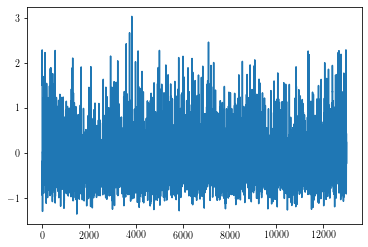

In [93]:
electrode = 106
responses = bnd_resp[2::2][0::2]
plt.plot(responses)

In [94]:
responses.shape

(13000,)

In [95]:
times_ds.shape

(13000,)

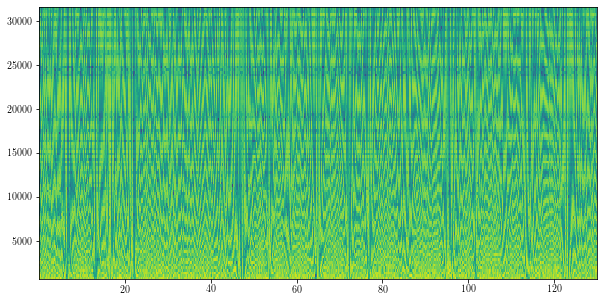

In [96]:
# compare spectrogram after downsampling
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.pcolormesh(times_ds, freq_ds, np.log(Sxx_ds))

## Full STRF

In [97]:
n_samples = times_ds.size - n_timepoints_strf_frame
n_features = Sxx_ds.shape[0] * n_timepoints_strf_frame

In [98]:
X = np.zeros((n_samples, n_features))
y = np.zeros(n_samples)

In [99]:
for sample in range(n_samples):
    base = sample
    end = base + n_timepoints_strf_frame
    X[sample] = Sxx_ds[:, base:end].ravel()
    y[sample] = responses[end]

In [100]:
ols = LinearRegression()
ols.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

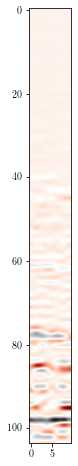

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
coef = ols.coef_.reshape((freq_ds.shape[0], n_timepoints_strf_frame))
ax.imshow(coef, origin='upper', cmap=plt.get_cmap('RdGy'), interpolation='spline36')

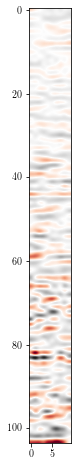

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
coef = ols.coef_.reshape((freq_ds.shape[0], n_timepoints_strf_frame))
ax.imshow(coef, origin='upper', cmap=plt.get_cmap('RdGy'), interpolation='spline36')

In [102]:
ols.score(X, y)

0.08203340725656716